In [1]:
# v1.2
# introduced 

# main issues:
# fix stop loss/ max wdd
# partial fills
# multiple pairs at one time
# issues with multiple pairs with similar legs, memory management
# trailing profit take
#     1) take 
#     1) sell bad leg and use winning leg to run    

# innovations
# increase volume
# make new models whcih are scalping or momentum models

# kalmans filters
# copulas
# nonlinear distributions
# extreme value theory
# last three are similar
# pair trading with multiple exchanges

# limit orders
# max win drawdown
# advanced risk mitigation 
# if long and first priotirty to get rid off -> sell at market
# if short and first prioity to get rid off -> sell at market
# pair splitting

In [2]:
# imports and requirements
import json
import requests
import pandas as pd
import numpy as np
import ccxt
import time
import datetime as dt
import matplotlib.pyplot as plt

from binance.client import Client
from binance.enums import *

In [3]:
# init client
apiKey = 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh'
apiSecret = 'bsY8Jh1A4jFNv8xLNWbRBff8MPoKQKeyB601YFoSRMiozHRZ4hj3m7pJFcMBIjy5'

# python-binance init
client = Client(apiKey, apiSecret)
# ccxt init
exchange = ccxt.binance({
    'apiKey': 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh',
    'secret': 'bsY8Jh1A4jFNv8xLNWbRBff8MPoKQKeyB601YFoSRMiozHRZ4hj3m7pJFcMBIjy5',
    'enableRateLimit': True,  # as required by the Manual
    'options': { 'defaultType': 'future' }
})

In [4]:
# inputs
# leg1 = input("Input leg 1: ")
# leg2 = input("Input leg 2: ")
# timeframe = input("Input timeframe/ interval: ")
# emalen = input("Input Lookback/ EMA length: ")
# legval = float(input("Leg Value: "))
    
leg1 = 'ONTUSDT'
leg2 = 'QTUMUSDT'
timeframe = '30m'
emalen = '20'
legval = float(input("Leg Value: "))

# convert legs
if leg1 == 'ONTUSDT':
    newLeg1 = 'ONT/USDT'
    prec1 = 4
elif leg1 == 'ETHUSDT':
    newLeg1 = 'ETH/USDT'
    prec1 = 2
elif leg1 == 'BCHUSDT':
    newLeg1 = 'BCH/USDT'
    prec1 = 2
elif leg1 == 'TRXUSDT':
    newleg1 = 'TRX/USDT'
    prec1 = 5
    
if leg2 == 'QTUMUSDT':
    newLeg2 = 'QTUM/USDT'
    prec2 = 3
elif leg2 == 'XTZUSDT':
    newLeg2 = 'XTZ/USDT'
    prec2 = 3
elif leg2 == 'LTCUSDT':
    newLeg2 = 'LTC/USDT'
    prec2 = 2
elif leg2 == 'BATUSDT':
    newLeg2 = 'BAT/USDT'
    prec2 = 4

print("New leg 1:", format(newLeg1))
print("New leg 2:", format(newLeg2))


Leg Value: 10
New leg 1: ONT/USDT
New leg 2: QTUM/USDT


In [5]:
# create dataframe
def dataframe(symbol, interval, timeframe):
    rootUrl = 'https://api.binance.com/api/v1/klines'
    url = rootUrl + '?symbol=' + symbol + '&interval=' + interval + '&limit=' + timeframe
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                 'o', 'h', 'l', 'c', 'v',
                 'closeTime', 'qav', 'numTrades',
                 'takerBase_Bol', 'takerQuoteVol', 'ignore']
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.closeTime]
    return df

dataframe(leg1, timeframe, emalen)

,open_time,o,h,l,c,v,closeTime,qav,numTrades,takerBase_Bol,takerQuoteVol,ignore
2020-06-07 07:29:59.999,1591477200000,0.57820000,0.57940000,0.57790000,0.57880000,39668.57000000,1591478999999,22955.20116100,72,17433.99000000,10089.40045500,0
2020-06-07 07:59:59.999,1591479000000,0.57860000,0.57930000,0.57780000,0.57910000,38648.28000000,1591480799999,22359.79467000,72,24841.31000000,14373.11967600,0
2020-06-07 08:29:59.999,1591480800000,0.57930000,0.58010000,0.57700000,0.57720000,67694.21000000,1591482599999,39168.81438800,148,29000.57000000,16801.12500100,0
2020-06-07 08:59:59.999,1591482600000,0.57790000,0.57800000,0.57550000,0.57620000,28456.61000000,1591484399999,16401.14399000,72,8859.23000000,5106.14002200,0
2020-06-07 09:29:59.999,1591484400000,0.57610000,0.57890000,0.57580000,0.57860000,37420.52000000,1591486199999,21606.91354100,89,23827.62000000,13760.92292400,0
2020-06-07 09:59:59.999,1591486200000,0.57860000,0.57970000,0.57710000,0.57750000,29231.16000000,1591487999999,16905.48978700,65,14770.37000000,8546.30932100,0
2020-06-07 10:29:59.999,1591488000000,0.57720000,0.57820000,0.57410000,0.57550000,66421.10000000,1591489799999,38247.19418900,177,24753.77000000,14250.07074800,0
2020-06-07 10:59:59.999,1591489800000,0.57530000,0.57780000,0.57490000,0.57780000,40518.95000000,1591491599999,23341.67197500,138,24414.04000000,14064.39006600,0
2020-06-07 11:29:59.999,1591491600000,0.57790000,0.57820000,0.57510000,0.57660000,31591.40000000,1591493399999,18215.75644300,84,14425.94000000,8317.64667100,0
2020-06-07 11:59:59.999,1591493400000,0.57660000,0.58030000,0.57660000,0.57960000,185057.10000000,1591495199999,107130.15207200,541,113880.21000000,65927.14086700,0


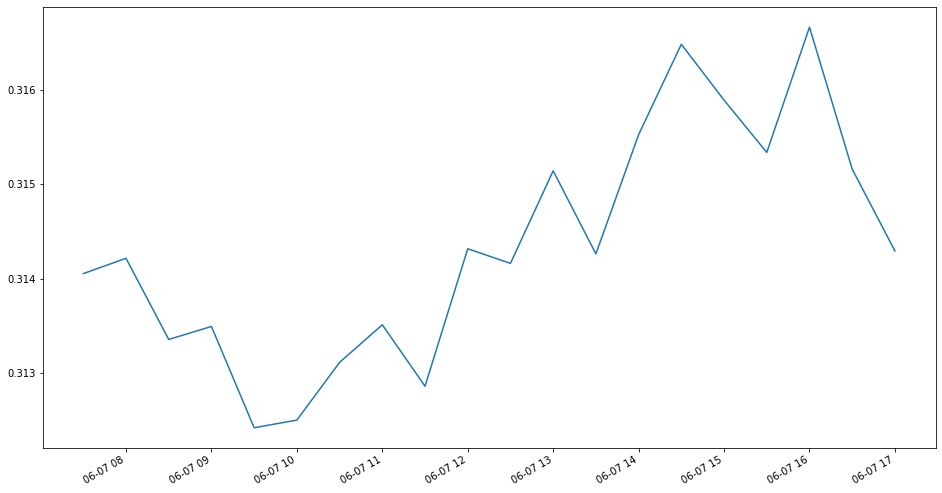

In [6]:
# hedge price function
def priceChart():
    leg1Chart= dataframe(leg1,timeframe, emalen)
    leg2Chart = dataframe(leg2,timeframe, emalen)

    leg1ChartClose = leg1Chart['c'].astype('float')
    leg2ChartClose = leg2Chart['c'].astype('float')

    hedgeChart = leg1ChartClose / leg2ChartClose
    return hedgeChart

# prints price chart
priceChart().plot(figsize=(16,9))

In [7]:
# current zscore
def currZscore():
    currStd = priceChart().std()
    currMean = priceChart().mean()
    a = priceChart().tolist()
    x = a[-1:]
    
    y = [float(i) for i in x]

    zscore = (y[0] - currMean)/currStd
    return round(zscore,5)

print("Current Z-Score = %s" % currZscore())

Current Z-Score = -0.03606


In [8]:
# short buy and long exit
def shortSide(leg1, leg2, legval):
    
    print("Short side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,1)
    print ("Amount of leg1: {}". format(amountLeg1))
    
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")


    # short leg1    
    order1 = exchange.createOrder(newLeg1, 'market', 'sell', amountLeg1)
    print("Shorted leg 1")
    print(order1)
    # long leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'buy', amountLeg2)
    print("Longed leg 2")
    print(order2)
    
    inPos = True
    print ("inPos status before exit checks: {}". format(inPos))
    print("-----")

    
    # exit conds
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore <= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'buy', amountLeg1)
            print("Long/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'sell', amountLeg2)
            print("Short/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds for new buy session..."
    entryConds()

In [9]:
# long buy
def longSide(leg1, leg2, legval):
    
    print("Long side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,1)
    print ("Amount of leg1: {}". format(amountLeg1))
    
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")
        
    # long leg1
    order1 = exchange.createOrder(newLeg1, 'market', 'buy', amountLeg1)
    print("Longed leg 1")
    print(order1)
    # short leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'sell', amountLeg2)
    print("Shorted leg 2")
    print(order2)
    print("-----")
    
    inPos = True
    print ("inPos status: {}". format(inPos))
    
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore >= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'sell', amountLeg1)
            print("Short/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'buy', amountLeg2)
            print("Long/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds"
    entryConds()

In [ ]:
# entry conds
def entryConds():
    entered = False
    print ("Entry status at start of loop: {}". format(entered))
    print("-----")
    
    while entered == False:
        enZscore = currZscore()
        print ("Entry Zscore: {}". format(enZscore))

        if enZscore >= 2:
            print("Entering short side")
            print("-----")
            entered = True
            shortSide(leg1,leg2,legval)
        elif enZscore <= -2:
            print("Entering long side")
            print("-----")
            entered = True
            longSide(leg1,leg2,legval)
        else:
            print("No entry. Sleeping 5 secs...")
            print("-----")
            time.sleep(5)

entryConds()

Entry status at start of loop: False
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.03606
No ent

Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15509
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.09453
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.09457
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.1777
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.1777
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.1777
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.1777
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.26526
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.26062
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.26062
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.26062
No 

Entry Zscore: -0.32027
No entry. Sleeping 5 secs...
-----
Entry Zscore: nan
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.30138
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.30218
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.05313
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.05313
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.05313
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.05313
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.05313
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.0115
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.11336
No en

Entry Zscore: 0.98245
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98245
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98245
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05849
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05849
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05849
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05849
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05849
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05849
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05849
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26673
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.24962
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.24962
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.24962
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.46191
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.46191
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.46191
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.46191
No entry.

Entry Zscore: 1.43417
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.43417
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.43417
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.43417
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.43417
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.29888
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26434
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26434
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26434
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26434
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26434
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26434
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.36711
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.36711
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.36711
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.36711
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.19444
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.19444
No entry.

Entry Zscore: 1.08994
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.93564
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06306
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80024
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.04998
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.92119
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.93391
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.65077
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.4432
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.6949
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.72534
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57082
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.69291
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.03098
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.03098
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.84526
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.84526
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.84526
No entry. S

Entry Zscore: 0.36066
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.36066
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.14733
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.1291
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.54538
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.54538
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.50546
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.46541
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.46541
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.33847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.33847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.33847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.33847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.33847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.65812
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.65812
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.65812
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.65812
No entry. 

Entry Zscore: 0.56432
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57009
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.64284
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.64284
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.72096
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.72096
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.64284
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.72096
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.75975
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.75975
No entry.

Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80048
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.923
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.794
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.794
No entry. Sleep

Entry Zscore: 0.51999
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.79291
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.91468
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.91468
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70847
No entry.